# Validation Framework

This notebook demonstrates Pulsim's validation framework for comparing simulation results against analytical solutions or reference data.

## Contents
1. ValidationResult Structure
2. Waveform Comparison
3. Analytical Solutions
4. Export Functions
5. Validation Examples

In [11]:
import pulsim as ps
import numpy as np
import matplotlib.pyplot as plt

## 1. ValidationResult Structure

The `ValidationResult` class holds comparison metrics between simulated and reference waveforms.

In [12]:
# Create ValidationResult
val_result = ps.ValidationResult()

print("ValidationResult fields:")
print(f"  name:              {val_result.test_name}")
print(f"  max_error:         {val_result.max_error}")
print(f"  rms_error:         {val_result.rms_error}")
print(f"  mean_error:        {val_result.mean_error}")
print(f"  correlation:       {val_result.max_relative_error}")
print(f"  passed:            {val_result.passed}")
print(f"  tolerance:         {val_result.error_threshold}")
print(f"  num_points:        {val_result.num_points}")

ValidationResult fields:
  name:              
  max_error:         0.0
  rms_error:         0.0
  mean_error:        0.0
  correlation:       0.0
  passed:            False
  tolerance:         0.001
  num_points:        0


## 2. Waveform Comparison

Use `compare_waveforms()` to compare two time-series signals.

In [13]:
# Generate test waveforms
t = np.linspace(0, 1, 1000)
f = 5.0  # 5 Hz

# Reference signal
reference = np.sin(2 * np.pi * f * t)

# Simulated signal with small error
noise = 0.01 * np.random.randn(len(t))
simulated = np.sin(2 * np.pi * f * t) + noise

# Create tuples of (time, value) for compare_waveforms
sim_tuples = list(zip(t.tolist(), simulated.tolist()))
ref_tuples = list(zip(t.tolist(), reference.tolist()))

# Compare waveforms
result = ps.compare_waveforms(
    "Sine Wave Test",
    sim_tuples,
    ref_tuples,
    0.05  # 5% tolerance
)

print("Waveform Comparison Result:")
print(f"  Name:        {result.test_name}")
print(f"  Max error:   {result.max_error:.4f}")
print(f"  RMS error:   {result.rms_error:.4f}")
print(f"  Mean error:  {result.mean_error:.4f}")
print(f"  Passed:      {result.passed}")
print(f"  Tolerance:   {result.error_threshold}")

Waveform Comparison Result:
  Name:        Sine Wave Test
  Max error:   0.0341
  RMS error:   0.0101
  Mean error:  0.0082
  Passed:      False
  Tolerance:   0.05


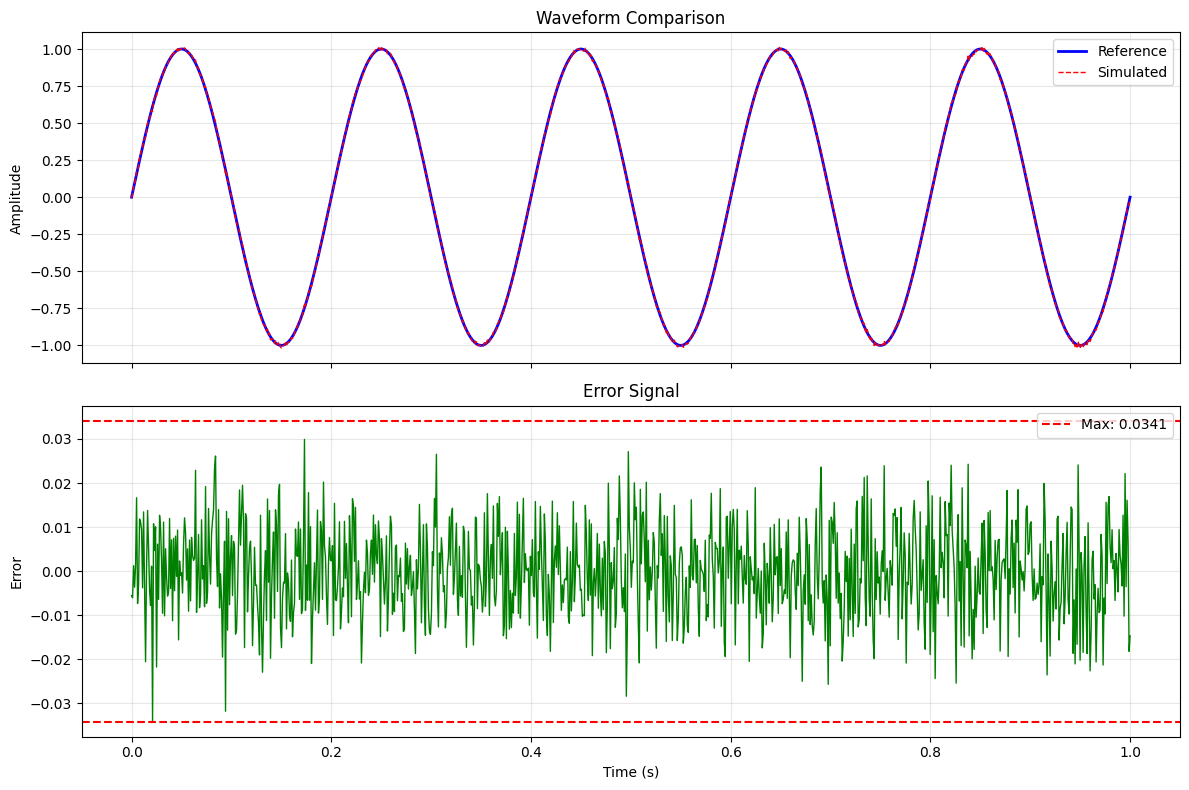

In [14]:
# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Waveforms
axes[0].plot(t, reference, 'b-', linewidth=2, label='Reference')
axes[0].plot(t, simulated, 'r--', linewidth=1, label='Simulated')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Waveform Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error
error = simulated - reference
axes[1].plot(t, error, 'g-', linewidth=1)
axes[1].axhline(y=result.max_error, color='r', linestyle='--', label=f'Max: {result.max_error:.4f}')
axes[1].axhline(y=-result.max_error, color='r', linestyle='--')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Error')
axes[1].set_title('Error Signal')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Analytical Solutions

Pulsim provides analytical solution classes for validation:

- `RCAnalytical` - RC circuit step response
- `RLAnalytical` - RL circuit step response  
- `RLCAnalytical` - RLC circuit step response

In [15]:
# RC Analytical Solution
R = 1000
C = 1e-6
V = 1.0

rc = ps.RCAnalytical(R, C, V_initial=0.0, V_final=V)

print("RCAnalytical:")
print(f"  R = {R} Ω")
print(f"  C = {C*1e6} µF")
print(f"  V = {V} V")
print(f"  τ = {rc.tau()*1000} ms")

# Sample voltage at key times
for t_mult in [0, 1, 2, 3, 5]:
    t = t_mult * rc.tau()
    v = rc.voltage(t)
    pct = v / V * 100
    print(f"  v({t_mult}τ) = {v:.4f} V ({pct:.1f}%)")

RCAnalytical:
  R = 1000 Ω
  C = 1.0 µF
  V = 1.0 V
  τ = 1.0 ms
  v(0τ) = 0.0000 V (0.0%)
  v(1τ) = 0.6321 V (63.2%)
  v(2τ) = 0.8647 V (86.5%)
  v(3τ) = 0.9502 V (95.0%)
  v(5τ) = 0.9933 V (99.3%)


In [16]:
# RL Analytical Solution
R_rl = 100
L = 10e-3
V_rl = 5.0

rl = ps.RLAnalytical(R_rl, L, V_rl, I_initial=0.0)

print("RLAnalytical:")
print(f"  R = {R_rl} Ω")
print(f"  L = {L*1000} mH")
print(f"  V = {V_rl} V")
print(f"  τ = {rl.tau()*1000} ms")
print(f"  I_final = V/R = {V_rl/R_rl*1000} mA")

# Sample current at key times
for t_mult in [0, 1, 2, 3, 5]:
    t = t_mult * rl.tau()
    i = rl.current(t)
    pct = i / (V_rl/R_rl) * 100
    print(f"  i({t_mult}τ) = {i*1000:.2f} mA ({pct:.1f}%)")

RLAnalytical:
  R = 100 Ω
  L = 10.0 mH
  V = 5.0 V
  τ = 0.1 ms
  I_final = V/R = 50.0 mA
  i(0τ) = 0.00 mA (0.0%)
  i(1τ) = 31.61 mA (63.2%)
  i(2τ) = 43.23 mA (86.5%)
  i(3τ) = 47.51 mA (95.0%)
  i(5τ) = 49.66 mA (99.3%)


In [17]:
# RLC Analytical Solution
R_rlc = 50
L_rlc = 1e-3
C_rlc = 1e-6
V_rlc = 1.0

rlc = ps.RLCAnalytical(R_rlc, L_rlc, C_rlc, V_rlc, V_initial=0.0, I_initial=0.0)

print("RLCAnalytical:")
print(f"  R = {R_rlc} Ω")
print(f"  L = {L_rlc*1000} mH")
print(f"  C = {C_rlc*1e6} µF")
print(f"  ζ (damping ratio) = {rlc.zeta():.3f}")
print(f"  ω₀ (natural freq) = {rlc.omega_0():.1f} rad/s")
print(f"  α (damping coeff) = {rlc.alpha():.1f}")
print(f"  Damping type: {rlc.damping_type()}")

RLCAnalytical:
  R = 50 Ω
  L = 1.0 mH
  C = 1.0 µF
  ζ (damping ratio) = 0.791
  ω₀ (natural freq) = 31622.8 rad/s
  α (damping coeff) = 25000.0
  Damping type: RLCDamping.Underdamped


## 4. Export Functions

Validation results can be exported to CSV or JSON for reporting.

In [18]:
# Export to CSV - takes a list of results and returns a string
csv_content = ps.export_validation_csv([result])
print("CSV Export:")
print(csv_content[:500] if len(csv_content) > 500 else csv_content)

# Export to JSON - takes a list of results and returns a string
json_content = ps.export_validation_json([result])
print("\nJSON Export:")
print(json_content[:500] if len(json_content) > 500 else json_content)

CSV Export:
test_name,passed,num_points,max_error,rms_error,max_relative_pct,threshold_pct
Sine Wave Test,false,1000,3.414089e-02,1.012062e-02,3.416209e+02,5.000000e+00


JSON Export:
{
  "validation_results": [
    {
      "test_name": "Sine Wave Test",
      "passed": false,
      "num_points": 1000,
      "max_error": 3.414089e-02,
      "rms_error": 1.012062e-02,
      "max_relative_pct": 3.416209e+02,
      "threshold_pct": 5.000000e+00
    }
  ]
}



## 5. Validation Examples

### 5.1 RC Circuit Validation

In [19]:
# Build and simulate RC circuit
def validate_rc_circuit(R, C, V_source):
    """Validate RC simulation against analytical solution."""
    # Build circuit
    ckt = ps.Circuit()
    gnd = ckt.ground()
    n_in = ckt.add_node("v_in")
    n_out = ckt.add_node("v_out")
    
    ckt.add_voltage_source("Vin", n_in, gnd, V_source)
    ckt.add_resistor("R1", n_in, n_out, R)
    ckt.add_capacitor("C1", n_out, gnd, C)
    
    # Simulate
    tau = R * C
    x0 = np.zeros(ckt.system_size())
    x0[0] = V_source
    
    t_stop = 5 * tau
    dt = tau / 100
    
    times, states, success, msg = ps.run_transient(ckt, 0.0, t_stop, dt, x0)
    
    if not success:
        return None
    
    # Get simulated and analytical
    times = np.array(times)
    v_sim = np.array([s[1] for s in states])
    
    rc_anal = ps.RCAnalytical(R, C, V_initial=0.0, V_final=V_source)
    v_anal = np.array([rc_anal.voltage(t) for t in times])
    
    # Create tuples for compare_waveforms
    sim_tuples = list(zip(times.tolist(), v_sim.tolist()))
    anal_tuples = list(zip(times.tolist(), v_anal.tolist()))
    
    # Compare
    result = ps.compare_waveforms(
        f"RC R={R} C={C}",
        sim_tuples,
        anal_tuples,
        0.01  # 1% tolerance
    )
    
    return result, times, v_sim, v_anal

# Run validation
result, t, v_sim, v_anal = validate_rc_circuit(1000, 1e-6, 1.0)

print(f"RC Validation:")
print(f"  Max error:   {result.max_error:.6f} V")
print(f"  RMS error:   {result.rms_error:.6f} V")
print(f"  Num points:  {result.num_points}")
print(f"  PASSED:      {result.passed}")

RC Validation:
  Max error:   0.004975 V
  RMS error:   0.001578 V
  Num points:  501
  PASSED:      False


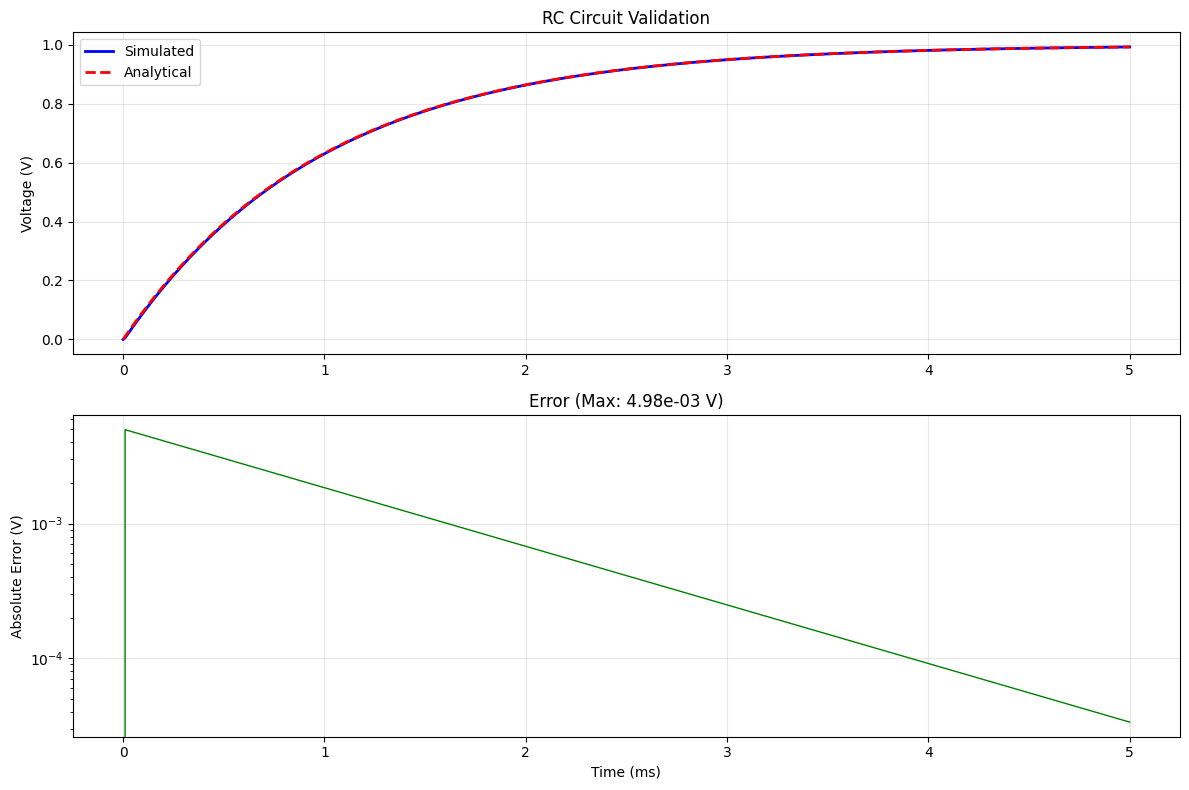

In [20]:
# Plot RC validation
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(t*1000, v_sim, 'b-', linewidth=2, label='Simulated')
axes[0].plot(t*1000, v_anal, 'r--', linewidth=2, label='Analytical')
axes[0].set_ylabel('Voltage (V)')
axes[0].set_title('RC Circuit Validation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].semilogy(t*1000, np.abs(v_sim - v_anal), 'g-', linewidth=1)
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Absolute Error (V)')
axes[1].set_title(f'Error (Max: {result.max_error:.2e} V)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Multi-Circuit Validation Suite

In [21]:
# Run validation suite
test_cases = [
    {"R": 100, "C": 1e-6},
    {"R": 1000, "C": 1e-6},
    {"R": 10000, "C": 1e-6},
    {"R": 1000, "C": 100e-9},
    {"R": 1000, "C": 10e-6},
]

print("Validation Suite Results:")
print("=" * 70)
print(f"{'R (Ω)':<10} {'C (µF)':<10} {'τ (ms)':<10} {'Max Err':<12} {'RMS Err':<12} {'Pass':<6}")
print("-" * 70)

all_passed = True
for tc in test_cases:
    result, _, _, _ = validate_rc_circuit(tc["R"], tc["C"], 1.0)
    tau = tc["R"] * tc["C"]
    
    status = "✓" if result.passed else "✗"
    print(f"{tc['R']:<10} {tc['C']*1e6:<10.2f} {tau*1000:<10.3f} {result.max_error:<12.2e} {result.rms_error:<12.2e} {status}")
    
    if not result.passed:
        all_passed = False

print("-" * 70)
print(f"Overall: {'ALL PASSED' if all_passed else 'SOME FAILED'}")

Validation Suite Results:
R (Ω)      C (µF)     τ (ms)     Max Err      RMS Err      Pass  
----------------------------------------------------------------------
100        1.00       0.100      4.98e-03     1.58e-03     ✗
1000       1.00       1.000      4.98e-03     1.58e-03     ✗
10000      1.00       10.000     4.98e-03     1.58e-03     ✗
1000       0.10       0.100      4.98e-03     1.58e-03     ✗
1000       10.00      10.000     4.98e-03     1.58e-03     ✗
----------------------------------------------------------------------
Overall: SOME FAILED


## Summary

### Validation Classes

| Class | Purpose |
|-------|---------|
| `ValidationResult` | Holds comparison metrics |
| `RCAnalytical` | RC circuit analytical solution |
| `RLAnalytical` | RL circuit analytical solution |
| `RLCAnalytical` | RLC circuit analytical solution |

### Key Functions

```python
# Compare waveforms - uses tuples of (time, value)
sim_tuples = list(zip(times, simulated))
ref_tuples = list(zip(times, reference))
result = ps.compare_waveforms(name, sim_tuples, ref_tuples, tolerance)

# Check result
if result.passed:
    print(f"Validation passed: max_error={result.max_error}")

# Export - takes a list of results, returns string
csv_str = ps.export_validation_csv([result])
json_str = ps.export_validation_json([result])

# Analytical solutions
rc = ps.RCAnalytical(R, C, V_initial=0.0, V_final=V)
v = rc.voltage(t)

rl = ps.RLAnalytical(R, L, V, I_initial=0.0)
i = rl.current(t)

rlc = ps.RLCAnalytical(R, L, C, V, V_initial=0.0, I_initial=0.0)
zeta = rlc.zeta()        # Damping ratio
w0 = rlc.omega_0()       # Natural frequency
dtype = rlc.damping_type()  # RLCDamping enum
```

**Next:** [DC Analysis](09_dc_analysis.ipynb)